## Citation for the MCEq

*Calculation of conventional and prompt lepton fluxes at very high energy*
A. Fedynitch, R. Engel, T. K. Gaisser, F. Riehn, T. Stanev,
EPJ Web Conf. 99 (2015) 08001
[arXiv:1503.00544](https://arxiv.org/abs/1503.00544)


In [ ]:
mceq = MCEqRun(
    interaction_model='SIBYLL23C',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)

mceq.solve()

mag = 3
muon_flux = (mceq.get_solution('mu+', mag) +
             mceq.get_solution('mu-', mag))
numu_flux = (mceq.get_solution('numu', mag) +
             mceq.get_solution('antinumu', mag))
nue_flux = (mceq.get_solution('nue', mag) +
            mceq.get_solution('antinue', mag))

plt.loglog(mceq.e_grid, muon_flux, label='muons')
plt.loglog(mceq.e_grid, numu_flux, label='muon neutrinos')
plt.loglog(mceq.e_grid, nue_flux, label='electron neutrinos')

plt.xlim(1., 1e9)
plt.xlabel('Kinetic energy (GeV)')
plt.ylim(1e-6, 1.)
plt.ylabel(r'$E^3 \cdot \Phi$')
plt.legend()
plt.show()

## Obtain the **Time-varying temperature profiles** across atmospheric layers

### 1. **NRLMSISE-00 Model** (MSIS00Atmosphere class)

**`NRLMSISE-00`** is an empirical model of the Earth’s atmosphere, which can be obtain by including class MCEq.geometry.density_profiles.`MSIS00Atmosphere`. This model can ONLY support two location parameter --- **"SouthPole”** and **“Karlsruhe”**. HOWEVER, by using build-in function `update_parameters()`, we can specify the value of `location_coord` to get the temperature profiles in arbitrary location on the earth.

NRL stands for the US Naval Research Laboratory. MSIS stands for **mass spectrometer** and **incoherent scatter radar**, the two primary data sources for development of earlier versions of the model. A primary use of this model is to aid predictions of satellite orbital decay due to atmospheric drag. So in the later version, NRLMSISE model get updated with actual satellite drag data. Over the years since introduction, NRLMSISE-00 has become the standard for international space research.

Reference
*NRLMSISE-00 empirical model of the atmosphere: Statistical comparisons and scientific issues* J. M. Picone, A. E. Hedin, D. P. Drob, A. C. Aikin, Ionosphere and Upper Atmosphere, 24 Dec 2002. [Link Here](https://doi.org/10.1029/2002JA009430)



In [ ]:

day_of_year = 0
nrlmS = models.MSIS00Atmosphere("SouthPole",doy=day_of_year)
nrlmK = models.MSIS00Atmosphere("Karlsruhe",doy=day_of_year)

nrlmBeiJing = models.MSIS00Atmosphere("SouthPole",doy=day_of_year)
nrlmBeiJing.update_parameters(location_coord=(116.4074,39.9042))
nrlmShenZhen = models.MSIS00Atmosphere("SouthPole",doy=day_of_year)
nrlmShenZhen.update_parameters(location_coord=(114.0579,22.5431))

nrlm_h = np.linspace(0,100,2000)
nrlmS_T = np.array([nrlmS.get_temperature(h) for h in nrlm_h*1000*100])
nrlmK_T = np.array([nrlmK.get_temperature(h) for h in nrlm_h*1000*100])
nrlmBeiJing_T = np.array([nrlmBeiJing.get_temperature(h) for h in nrlm_h*1000*100])
nrlmShenZhen_T = np.array([nrlmShenZhen.get_temperature(h) for h in nrlm_h*1000*100])

plt.figure(figsize=(15,5))
plt.xlim((nrlm_h[0],nrlm_h[-1]))
plt.plot(nrlm_h,nrlmS_T,label='SouthPole')
plt.plot(nrlm_h,nrlmK_T,label='Karlsruhe')
plt.plot(nrlm_h,nrlmBeiJing_T,label='BeiJing')
plt.plot(nrlm_h,nrlmShenZhen_T,label='ShenZhen')
plt.grid()
plt.xlabel('Height (km)')
plt.ylabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title(f'Temperature Profiles on \n Day {day_of_year} of an year')
plt.show()

### 2. **Corsika Atmosphere** Model (CorsikaAtmosphere class)


Available atmospheres: 

| Model | Location | Time | Note | Explanation|
|--------|--------|--------|--------|--------|
| USStd  | None   | None   | \      |  U.S. Standard Atmosphere 1976 |
| BK_USStd  | None   | None   | \      | |
| KM3NeT  | Mediterranean Sea   | None   | \      | kilometre cubic neutrino telescope (KM3NeT)  |
| ANTARES/KM3NeT-ORCA  | Mediterranean Sea   | **Seasonal**   | Spring and Autumn Excluded  | |
| KM3NeT-ARCA  | Mediterranean Sea   | **Seasonal**   | Spring and Autumn Excluded      |  |
| SouthPole  | SouthPole   | **monthly**   | Only December and June  | |
| PL_SouthPole  | SouthPole   | **monthly**   | Only January and August  | |
| SDR_SouthPole  | SouthPole   | **monthly**   | \  | |



In [ ]:
corsiakaF = models.CorsikaAtmosphere('SDR_SouthPole','February')
corsiakaS = models.CorsikaAtmosphere('SDR_SouthPole','September')

corsiaka_h = np.linspace(0,100,2000)
corsiakaF_T = np.array([corsiakaF.get_density(h) for h in corsiaka_h*1000*100])
corsiakaS_T = np.array([corsiakaS.get_density(h) for h in corsiaka_h*1000*100])

plt.figure(figsize=(15,5))
plt.xlim((nrlm_h[0],nrlm_h[-1]))
plt.yscale('log')
plt.plot(corsiaka_h,corsiakaF_T,label='February')
plt.plot(corsiaka_h,corsiakaS_T,label='September')
plt.grid()
plt.xlabel('Height (km)')
plt.ylabel('Density (g/cm^3)')
plt.legend(loc='upper right')
plt.title(f'Density Profiles in SouthPole')
plt.show()

### 3. **Using Other Database** (Implement `EarthsAtmosphere` **virtual** class)

Abstract class containing common methods on atmosphere. We have to **inherit** from this class and implement the virtual method `get_density()`.


| Database Name| Categories | Providing Agency | Access |
| ---------| ---------| ---------| ---------|
| **ERA5** | Reanalysis Data| European Centre for Medium-Range Weather Forecasts(ECMWF) | [Link](https://cds.climate.copernicus.eu) |
| MERRA-2 | Reanalysis Data| NASA | |
| JRA-55 | Reanalysis Data| Japan Meteorological Agency (JMA) |  |
| IGRA | Observational Data| NOAA | [Link](https://www.ncei.noaa.gov/access/weather/igra/) |
| ARM | Observational Data| U.S Department of Energy |  |
| AIRS | Satellite Remote Sensing Data| NASA(Aqua Satellite) | [Link](https://disc.gsfc.nasa.gov/) |
| IASI | Satellite Remote Sensing Data| EUMETSAT(Metop Satellites) |  |

#### MERRA-2 from NASA's erathaccess
Following Dataset could be helpful

- https://urs.earthdata.nasa.gov/profile
- https://www.earthdata.nasa.gov/data/tools/earthaccess
- https://earthaccess.readthedocs.io/en/latest/

*From github*: **[GES DISC]**
- https://github.com/nasa/gesdisc-tutorials

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline

import crflux.models as crf
from MCEq.core import config, MCEqRun

import MCEq.geometry.density_profiles as models

from ipywidgets import IntProgress,HTML,HBox
from IPython.display import display

h:\Anaconda\envs\mceq_muon\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import dask
import earthaccess
import xarray as xr

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login(strategy="environment")

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('2025-05-01', '2025-05-02'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

files = earthaccess.open(results)

ds = xr.open_mfdataset(
    files,
    engine='h5netcdf'
    )

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 48, lat: 361, lon: 576)
Coordinates:
  * lon       (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * lat       (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 384B 2025-05-01T00:30:00 ... 2025-05-02T2...
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 40MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 40MB dask.array<chunk

In [4]:
print("数据集变量:", list(ds.data_vars.keys()))
print("数据集坐标:", list(ds.coords.keys()))

数据集变量: ['CLDPRS', 'CLDTMP', 'DISPH', 'H1000', 'H250', 'H500', 'H850', 'OMEGA500', 'PBLTOP', 'PS', 'Q250', 'Q500', 'Q850', 'QV10M', 'QV2M', 'SLP', 'T10M', 'T250', 'T2M', 'T2MDEW', 'T2MWET', 'T500', 'T850', 'TO3', 'TOX', 'TQI', 'TQL', 'TQV', 'TROPPB', 'TROPPT', 'TROPPV', 'TROPQ', 'TROPT', 'TS', 'U10M', 'U250', 'U2M', 'U500', 'U50M', 'U850', 'V10M', 'V250', 'V2M', 'V500', 'V50M', 'V850', 'ZLCL']
数据集坐标: ['lon', 'lat', 'time']


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

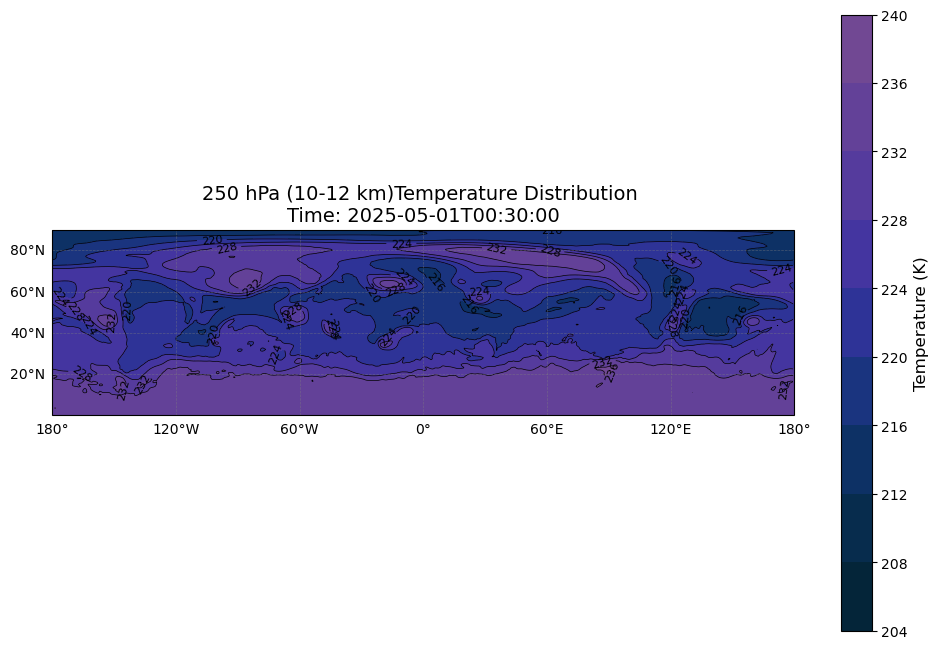

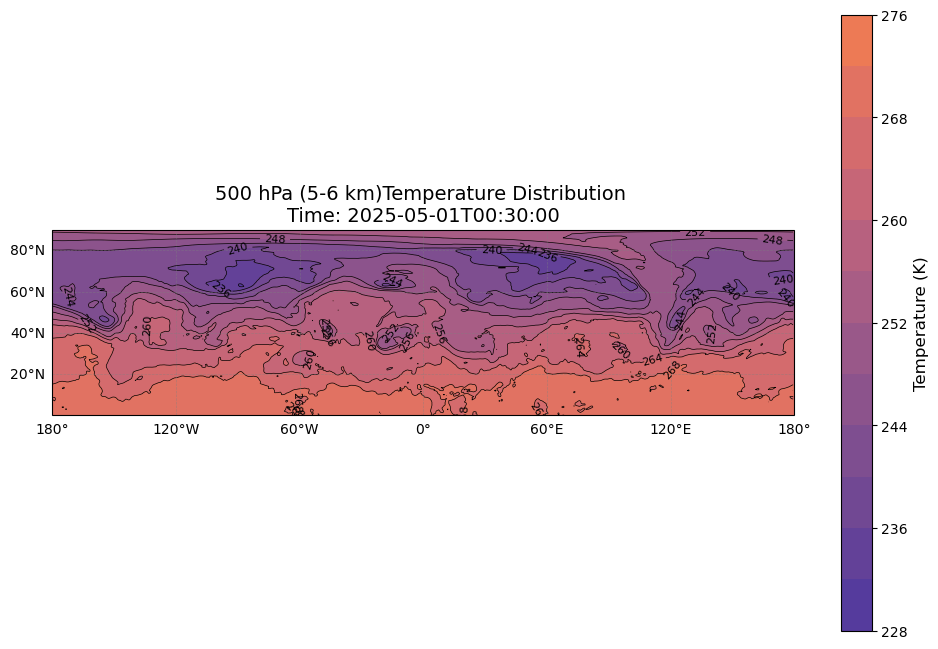

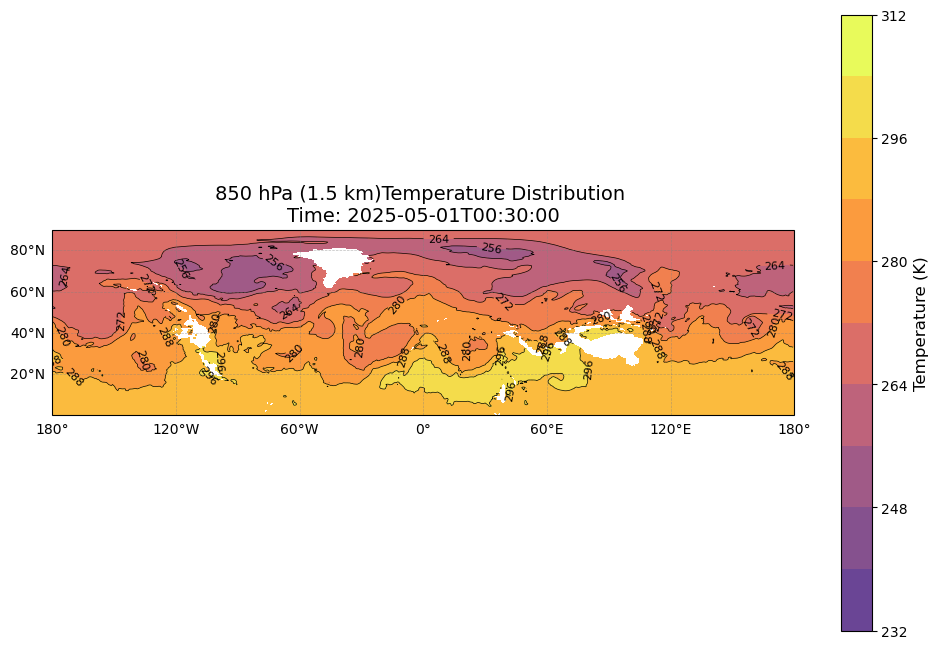

In [6]:
# 选择要可视化的气压层
pressure_levels = ['T250', 'T500', 'T850']
pressure_titles = {
    'T250': '250 hPa (10-12 km)',
    'T500': '500 hPa (5-6 km)',
    'T850': '850 hPa (1.5 km)'
}

# 选择时间点 - 使用第一个时间点
time_idx = 0
time_str = str(ds.time.isel(time=time_idx).values)[:19]

# 检查哪些气压层变量存在
available_levels = [var for var in pressure_levels if var in ds.data_vars]

# 为所有子图设置统一的最小和最大温度值，确保颜色条一致
vmin = min([ds[level].min().values for level in available_levels])
vmax = max([ds[level].max().values for level in available_levels])

# 分别绘制每个气压层的温度分布图
for level in available_levels:
    # 创建新图形
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 获取该气压层的温度数据
    temp_data = ds[level].isel(time=time_idx)
    
    # 设置地图范围
    ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
    
    # 绘制温度分布
    contour = ax.contourf(
        temp_data.lon, temp_data.lat, temp_data,
        levels=10, 
        vmin=vmin, vmax=vmax,
        cmap='cmo.thermal',  # 使用海洋学颜色映射
        transform=ccrs.PlateCarree()
    )
    
    # 添加等高线
    contour_lines = ax.contour(
        temp_data.lon, temp_data.lat, temp_data,
        levels=10,
        colors='black',
        linewidths=0.5,
        transform=ccrs.PlateCarree()
    )
    
    # 添加等高线标签
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f')
    
    # 添加网格线
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # 添加颜色条
    cbar = plt.colorbar(contour, ax=ax, shrink=0.8)
    cbar.set_label(f"Temperature ({ds[level].attrs.get('units', 'K')})", fontsize=12)
    
    # 添加标题
    plt.title(f"{pressure_titles[level]}Temperature Distribution \nTime: {time_str}", fontsize=14)
    
    # 保存图像
    plt.tight_layout()
    plt.show()

#### How to use it
ERA5 provides precise dataset of the atmosphere. However the process will be quite complex. ERA5 dataset DO NOT include the AlTITUDE and the DENSITY directly, which means we need to derive them from other varables. 

- Altitude

We can get altitude info from `Geopotential`. This parameter is the gravitational potential energy of a unit mass, at a particular location, relative to mean sea level. It is also the amount of work that would have to be done, against the force of gravity, to lift a unit mass to that location from mean sea level. The geopotential height can be calculated by dividing the geopotential by the Earth's gravitational acceleration, $g (9.80665 m \cdot s{-2})$.

- Density

If the atmospheric layers were treated as **static ideal gases**, their densities could be determined by the ideal gas law. However, variations in air composition across difference layers --- particularly significant changes in humindity --- combined with atmospheric flow, make density calculations particularly complex. 


### Daya Bay

All distances have been surveyed with the Global Positioning System (GPS) and with modern theodolites utilizing two major control networks built over several months.

- https://arxiv.org/abs/hep-ex/0701029v1

